# Google Play Store Apps - NLP Project
## Web scraped data of 10k Play Store apps for analysing the Android market.

An NLP approach for Google Play Store App Reviews with Text Processing, NER, Topic Modeling, Sentiment Analysis and WordClouds.<br>
We process the texts, like removing numbers, enter lines and stopwords and using methods like NER and Topic Modeling and its visualization with WordClouds. We use different Classifiers for Text Classificaton and TextBlob for Sentiment Analysis.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/datasets/lava18/google-play-store-apps?select=googleplaystore_user_reviews.csv

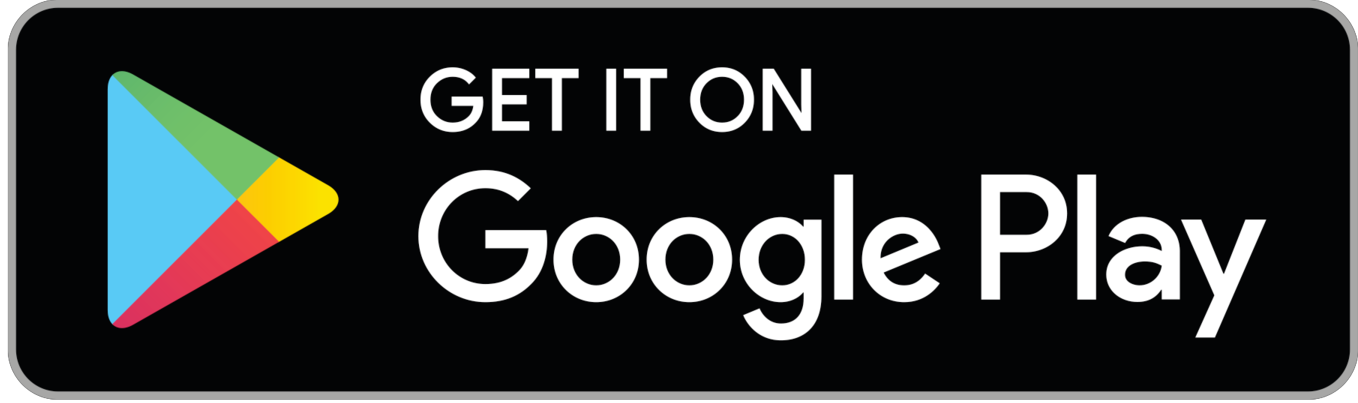

# Import Libraries and Load Data

In [1]:
#pip install svgling - was needed to show the entities (NER)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 317.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk # for NER
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/google-play-store-apps/googleplaystore.csv
/kaggle/input/google-play-store-apps/license.txt
/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv
/kaggle/input/silhoutte2/down.png
/kaggle/input/silhoutte2/up.png
/kaggle/input/silhoutte2/neutral.png
/kaggle/input/silhoutte2/play.png


In [5]:
# load data and drop empty entries
df=pd.read_csv("/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv").dropna()
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [7]:
df.App.nunique() # see how many apps

865

We have a total of 865 apps that got reviews.

# EDA - Exploratory Data Analysis

In [4]:
df.info() # infos about the samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     37427 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37427 non-null  object 
 3   Sentiment_Polarity      37427 non-null  float64
 4   Sentiment_Subjectivity  37427 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.7+ MB


In [5]:
df.isnull().sum() # checking for missing values

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

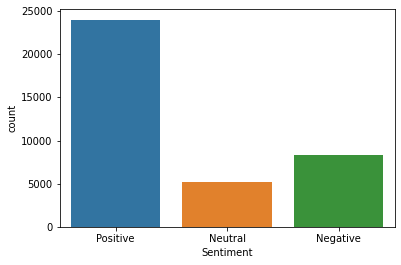

In [6]:
sns.countplot(x=df["Sentiment"]); # plot the classes

After removing empty values, we have 37427 samples, 5 features and no empty values. We do not have an even distribution of positive and negative reviews. Most of them are Positive.

## Text Processing in NLP projects:

* Convert all text to lowercase
* Remove punctuation marks
* Remove numbers
* Remove line break and enter \r \n
* Tokenize the text
* Stop words (remove unnecessary words)
* Remmove suffixes with Lemma and Stemma and find roots
* Using NER
* Convert texts to numbers with Vectorize

In [7]:
# function to process text, including Tokenizing, Lemmatizing and Stemmatizing, Stop Words removals and NER
def preprocess_text(df, text_column, processed_column='text_processed', tokens_column='text_tokens', lemma_column='text_lemmatize', entities_column='text_entities'):
    # Convert text to lowercase and remove punctuation, numbers, and line breaks
    df[processed_column] = df[text_column].str.lower().apply(lambda x: re.sub(r'[^\w\s]|\d|\r|\n', '', x))
    
    # Tokenize the text of processed text
    df[tokens_column] = df[processed_column].apply(lambda x: nltk.word_tokenize(x))
    
    # Remove stop words from tokenized text
    stop_words = set(stopwords.words('english'))
    df[tokens_column] = df[tokens_column].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Remmove suffixes with Lemma and Stemma and find roots
    df[lemma_column] = df[tokens_column].apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(word)) for word in x])
    
    # NER - Extract named entities
    df[entities_column] = df[tokens_column].apply(lambda x: ne_chunk(pos_tag(x)))
    
    return df

In [8]:
df = preprocess_text(df, 'Translated_Review')

In [9]:
# Let's have a look at our processed Data Frame
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,text_processed,text_tokens,text_lemmatize,text_entities
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,i like eat delicious food thats im cooking foo...,"[like, eat, delicious, food, thats, im, cookin...","[like, eat, delici, food, that, im, cook, food...","[(like, IN), (eat, NN), (delicious, JJ), (food..."
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,this help eating healthy exercise regular basis,"[help, eating, healthy, exercise, regular, basis]","[help, eat, healthi, exercis, regular, basi]","[(help, NN), (eating, VBG), (healthy, JJ), (ex..."
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,works great especially going grocery store,"[works, great, especially, going, grocery, store]","[work, great, especi, go, groceri, store]","[(works, VBZ), (great, JJ), (especially, RB), ..."
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,best idea us,"[best, idea, us]","[best, idea, u]","[(best, JJS), (idea, NN), (us, PRP)]"
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,best way,"[best, way]","[best, way]","[(best, JJS), (way, NN)]"


Let's have a deeper look what our columns look like

In [10]:
df.text_processed[0] # show first processed text

'i like eat delicious food thats im cooking food myself case  best foods helps lot also best before shelf life'

We can see that the text is all in lower case, without punctuation marks, numbers or line breaks.

In [11]:
df.text_tokens[0] # show first tokenized text

['like',
 'eat',
 'delicious',
 'food',
 'thats',
 'im',
 'cooking',
 'food',
 'case',
 'best',
 'foods',
 'helps',
 'lot',
 'also',
 'best',
 'shelf',
 'life']

In [12]:
df.text_lemmatize[0] # show first lemmatized text

['like',
 'eat',
 'delici',
 'food',
 'that',
 'im',
 'cook',
 'food',
 'case',
 'best',
 'food',
 'help',
 'lot',
 'also',
 'best',
 'shelf',
 'life']

**Named Entity Recognition (NER)** is a technique used in natural language processing (NLP) to identify and classify named entities in text data. Named entities are specific words or phrases that represent real-world objects, such as people, organizations, locations, and dates.

In [13]:
df.text_entities # show entities of text

0        [(like, IN), (eat, NN), (delicious, JJ), (food...
1        [(help, NN), (eating, VBG), (healthy, JJ), (ex...
3        [(works, VBZ), (great, JJ), (especially, RB), ...
4                     [(best, JJS), (idea, NN), (us, PRP)]
5                                 [(best, JJS), (way, NN)]
                               ...                        
64222    [(ads, NNS), (older, VBP), (many, JJ), (agents...
64223    [(photos, NNS), (posted, VBD), (portal, JJ), (...
64226    [(dumb, JJ), (app, NN), (wanted, VBD), (post, ...
64227    [(property, NN), (business, NN), (got, VBD), (...
64230    [(useless, JJ), (app, NN), (searched, VBD), (f...
Name: text_entities, Length: 37427, dtype: object

Here we can see the results of NER, let's look closer in a nice diagram.

**part-of-speech (POS)** tagging is a process of marking each word in a text with a POS tag to indicate its grammatical role in the sentence. They are typically represented as a sequence of symbols that follow each word in the text, with each symbol representing a specific grammatical role.
For example: NN: Noun, singular or mass, JJ: Adjective, VB: Verb..


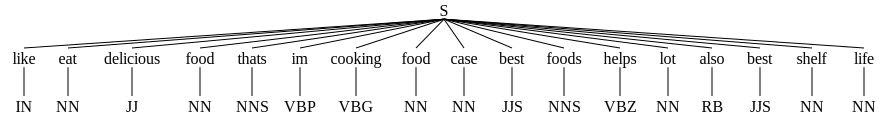

In [14]:
df.text_entities[0] # show entities of first text visualized

We can see that our function did a great job in Text Processing. It was designed with the help of ChatGPT.

# Topic Modelling

In topic modelling, the goal is to identify the main topics or themes discussed in the text data and represent each document as a mixture of these topics. This is done by representing each document as a vector of weights, where each weight represents the relevance of a specific topic to the document.

In [15]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

def topic_modeling(documents, dictionary, num_topics=10, num_words=10):
    # Create a corpus from the documents
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    # Train the LDA model on the corpus
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    
    # Print the top words for each topic
    for i, topic in lda.show_topics(num_words=num_words, formatted=False):
        print(f'Topic {i}: {[word for word, _ in topic]}')
    
    return lda

# Extract the list of documents from the DataFrame
documents = df['text_tokens'].tolist()

# Create a dictionary of the documents
dictionary = Dictionary(documents)

# Apply the topic modeling function to the documents
lda = topic_modeling(documents, dictionary=dictionary)

# Assign the topic assignments to a new column in the DataFrame
df['topics'] = [lda[dictionary.doc2bow(doc)] for doc in documents]

Topic 0: ['get', 'money', 'pay', 'time', 'like', 'dont', 'levels', 'never', 'cant', 'free']
Topic 1: ['great', 'app', 'works', 'prices', 'awesome', 'hotel', 'room', 'time', 'score', 'phone']
Topic 2: ['game', 'play', 'time', 'fun', 'ads', 'get', 'level', 'like', 'ad', 'love']
Topic 3: ['best', 'ive', 'app', 'photos', 'ever', 'htc', 'save', 'im', 'data', 'cards']
Topic 4: ['love', 'nice', 'would', 'ads', 'like', 'app', 'many', 'could', 'great', 'way']
Topic 5: ['easy', 'like', 'use', 'app', 'love', 'amazing', 'really', 'super', 'perfect', 'great']
Topic 6: ['good', 'like', 'new', 'news', 'app', 'see', 'also', 'cool', 'deals', 'might']
Topic 7: ['really', 'bad', 'like', 'better', 'way', 'much', 'put', 'useful', 'think', 'weather']
Topic 8: ['update', 'please', 'phone', 'screen', 'cant', 'fix', 'working', 'work', 'add', 'open']
Topic 9: ['google', 'work', 'phone', 'account', 'even', 'cant', 'email', 'support', 'version', 'get']


In [16]:
df.topics[0]

[(0, 0.17241395),
 (1, 0.22030829),
 (3, 0.4016468),
 (5, 0.09380073),
 (7, 0.08400147)]

This indicates that the text is assigned to topic 3 with a probability of 40%, topic 1 with 22% and so on. This means that the document is more likely to belong to topic 3 according to the topic modeling algorithm.

## Visualize Topics

Here is an example of how you can visualize a single topic with a Wordcloud. Change the Id in the last column to make a Wordcloud of other topics.

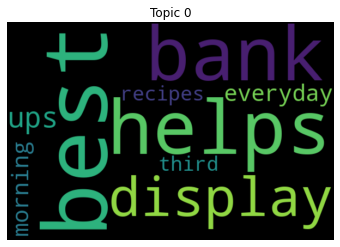

In [17]:
from wordcloud import WordCloud

def visualize_topic(lda, dictionary, topic_id):
    # Create a list of the top words for the topic
    top_words = [word for word, _ in lda.show_topic(topic_id, topn=10)]
    
    # Create a word cloud for the topic
    wordcloud = WordCloud(width=600, height=400).generate(' '.join(top_words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {topic_id}')
    plt.show()

# Extract the list of documents from the DataFrame
documents = df['text_tokens'].tolist()

# Create a dictionary of the documents
dictionary = Dictionary(documents)

# Train the LDA model on the corpus
lda = LdaModel([dictionary.doc2bow(doc) for doc in documents], id2word=dictionary)

# Visualize the topic with ID 0
visualize_topic(lda, dictionary, 0)

# Modelling - Text Classification

After assignin our X (features) and y (target), we use a Vectorizer to convert our text documents into a matrix, then we split our data to train and test sets and with various Classifiers we try to train our Model.
The CountVectorizer is a tool from the scikit-learn library that can be used to convert a collection of text documents into a matrix of token counts.

In [18]:
# turn categorical to integer
df.Sentiment.replace({'Positive':1,'Negative':2,'Neutral':0},inplace=True)
df.Sentiment.unique()

array([1, 0, 2])

In [19]:
# assign x and y - features are texts and target is label
x,y =df["text_processed"], df["Sentiment"]
# Vectorize text data, removing stop words
vect=CountVectorizer(stop_words="english",ngram_range=(1,1))
x=vect.fit_transform(x)
# split to train and test data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [20]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
result = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    result.loc[i] = [classifier_names[i], score]

In [21]:
# sort the dataframe by the accuracy column in descending order
result.sort_values(by='accuracy', ascending=False, inplace=True)
result # show results

,classifier,accuracy
3,RandomForestClassifier,0.910240
1,DecisionTreeClassifier,0.891541
4,XGBClassifier,0.886376
0,MultinomialNB,0.789136
2,KNeighborsClassifier,0.731077


We can see that the best result shows the **RandomForestClassifier with an Accuracy of 91,02%**, followed by the DecisionTreeClassifier with similar accuracy.

# Wordclouds

**Wordclouds (WC)** allow us the visual representations of the frequency and relative importance of words in a given body of text.

In [22]:
# Function to create a Wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(20,20))
    mask=np.array(Image.open("/kaggle/input/silhoutte2/play.png"))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask) 
    wc.generate(' '.join(data)) 
    plt.imshow(wc) 
    plt.axis("off")

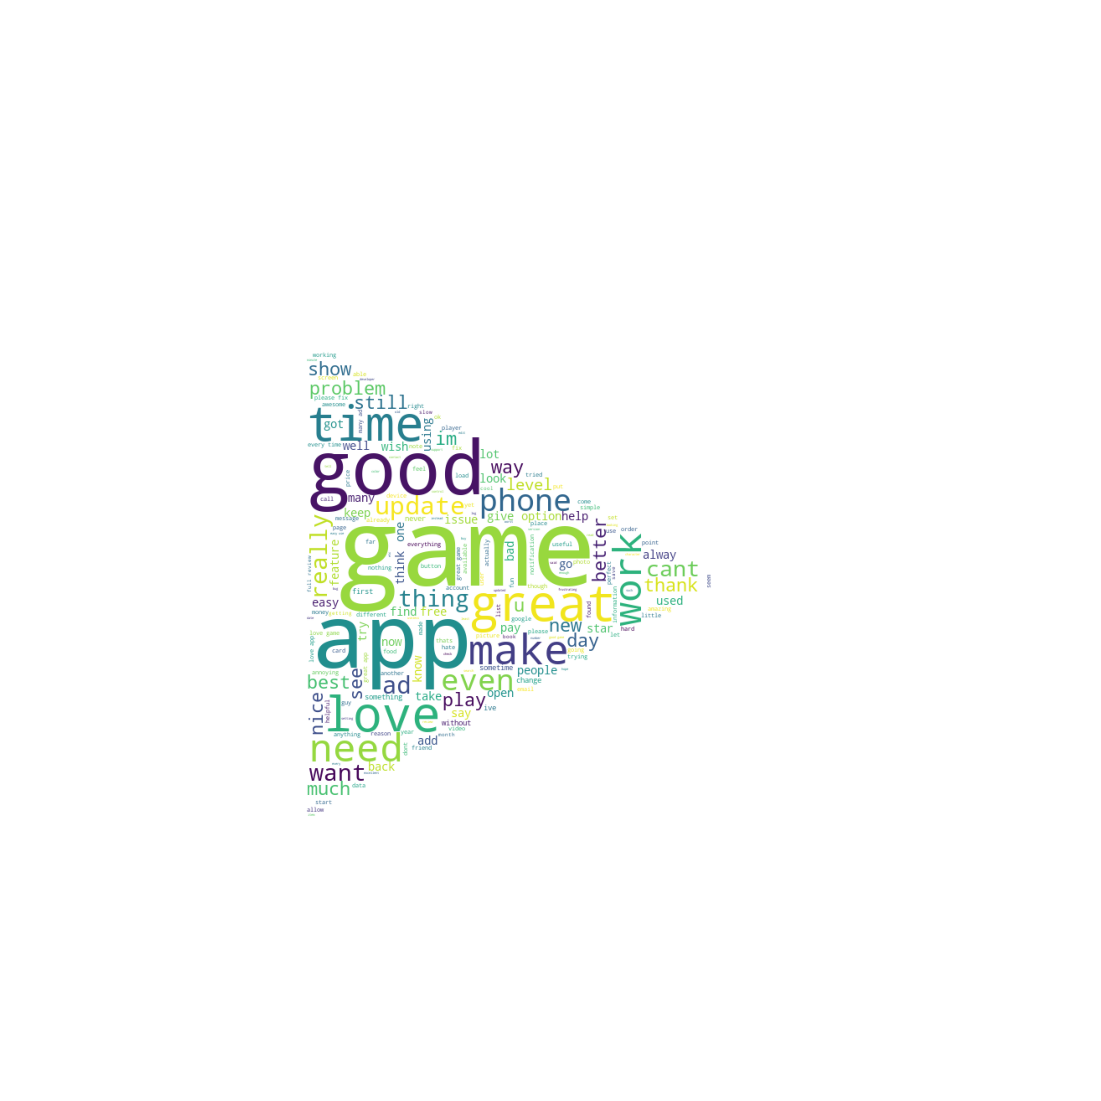

In [23]:
wc(df.text_processed,'white') # WC for processed text

# Sentiment Analysis - Using TextBlob

Sentiment analysis with TextBlob: TextBlob can perform sentiment analysis on a text, which involves determining the overall sentiment expressed in the text (e.g., positive, negative, neutral).


**Epsilon Neighborhood**

In the context of sentiment analysis, epsilon neighborhoods can be used to identify reviews that express similar sentiments. For example, we might define an epsilon neighborhood around a review that is very positive, and then identify all other reviews that fall within that neighborhood as also being very positive.

In [24]:
# function for sentiment analysis
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

# 1 positive, # 2 negative, # 0 neutral
def detect_sentiment(sent):
    if sent<-0.02: #0.02:limit
        return 2
    elif sent>0.02:
        return 1
    else:
        return 0

In [25]:
# define new dataframe
df_sent=df[["text_processed"]] 
df_sent.head()

,text_processed
0,i like eat delicious food thats im cooking foo...
1,this help eating healthy exercise regular basis
3,works great especially going grocery store
4,best idea us
5,best way


In [26]:
# call sentiment function on our text and create new column with values
df_sent["polarity"]=df_sent["text_processed"].apply(detect_polarity)
df_sent["sentiment"]=df_sent["polarity"].apply(detect_sentiment)
df_sent.head()

,text_processed,polarity,sentiment
0,i like eat delicious food thats im cooking foo...,1.00,1
1,this help eating healthy exercise regular basis,0.25,1
3,works great especially going grocery store,0.40,1
4,best idea us,1.00,1
5,best way,1.00,1


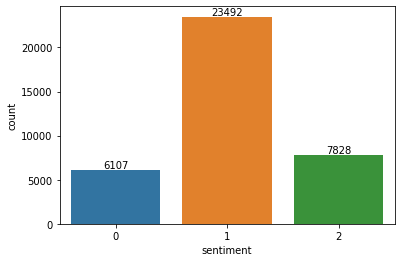

In [27]:
ax=sns.countplot(df_sent.sentiment); # plot the sentiment analysis
ax.bar_label(ax.containers[0]);

We have 23492 positive, 7828 negative and 6107 neutral reviews.

## Modeling - Sentiment Analysis with TextBlob

In [28]:
# assign x and y
x_s, y_s=df.text_processed, df.Sentiment
# Vectorize X
vect=CountVectorizer(stop_words="english",ngram_range=(1,1))
x_s=vect.fit_transform(x_s) 
# split into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x_s,y_s,random_state=42,test_size=.15)

In [29]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
df2 = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    df2.loc[i] = [classifier_names[i], score]

In [30]:
# sort the dataframe by the accuracy column in descending order
df2.sort_values(by='accuracy', ascending=False, inplace=True)
df2 # show results

,classifier,accuracy
3,RandomForestClassifier,0.909172
1,DecisionTreeClassifier,0.891362
4,XGBClassifier,0.886376
0,MultinomialNB,0.789136
2,KNeighborsClassifier,0.731077


Using TextBlob for the Sentiment Analysis, the **RandomForestClassifier** scored the highest with an **Accurcy of 90,92%**

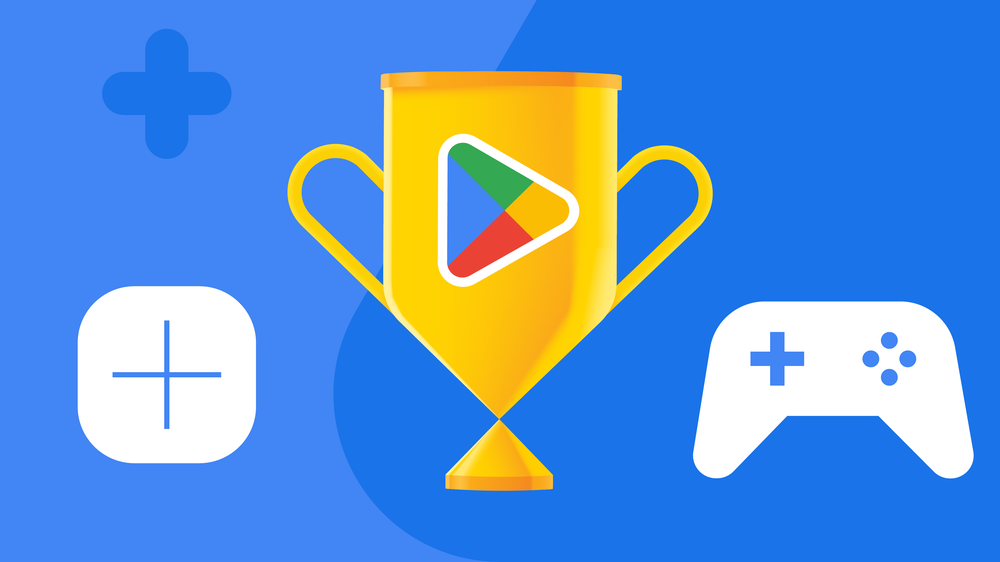